In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Setup batch size and data loaders

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Use Matplot lib to see a few data examples

images shape:  torch.Size([32, 3, 32, 32])
temp:  torch.Size([3, 32, 32])
temp.view(-1).shape:  torch.Size([3072])
img shape:  (3, 138, 274)


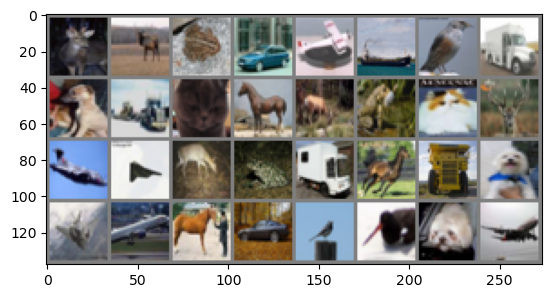

deer  deer  frog  car   plane ship  bird  truck dog   truck cat   horse deer  frog  cat   deer  plane plane deer  frog  truck horse truck dog   plane plane horse car   bird  bird  dog   plane


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print("img shape: ", npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print("images shape: ", images.shape)
temp = images[0]
print("temp: ", temp.shape)

print("temp.view(-1).shape: ", temp.view(-1).shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Let us understand the shapes of the data
First let us look at the images structures

In [5]:
print("images shape: ", images.shape)


images shape:  torch.Size([32, 3, 32, 32])


Images is a batch of 4 images. An each image has a shape of 3 x 32 x 32. Let us look in more detail

In [6]:
temp = images[0]
print("temp: ", temp.shape)

temp:  torch.Size([3, 32, 32])


In this case, the image an RGB color image, where each of the three colors is called a channel.
The image is squared, with 32 rows and 32 columns. Hence the shape of the imahe is 3 x 32 x 32.
In the image was gray scale, then it would have shape of 1 x 32 x 32.

In you are to feed an image to a fully connected network, then each pixel would be a feature! 
Thus, the input to the network would have size: 3 x 32 x 32 = 3072. We would need to "flatten"
the image with the following command: view(-1)

In [7]:
print("temp.view(-1).shape: ", temp.view(-1).shape)


temp.view(-1).shape:  torch.Size([3072])


Lets now define a conv nueral  network with hidden layers and one output layer.


In [8]:
import torch.nn as nn

class NNModel (nn.Module):
    def __init__(self, input_size):
        super(NNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.out_activation = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.out_activation(x)
        return x

nnet = NNModel(3072)


Now lets look the neural network

In [10]:
from torchinfo import summary

batch_size = 32 #for illustration

summary(nnet, input_size=(batch_size, 3, 32, 32), device='cpu', col_names=['input_size', 'output_size',
                                                                           'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NNModel                                  [32, 3, 32, 32]           [32, 10]                  --
├─Conv2d: 1-1                            [32, 3, 32, 32]           [32, 6, 28, 28]           456
├─ReLU: 1-2                              [32, 6, 28, 28]           [32, 6, 28, 28]           --
├─MaxPool2d: 1-3                         [32, 6, 28, 28]           [32, 6, 14, 14]           --
├─Conv2d: 1-4                            [32, 6, 14, 14]           [32, 16, 10, 10]          2,416
├─ReLU: 1-5                              [32, 16, 10, 10]          [32, 16, 10, 10]          --
├─MaxPool2d: 1-6                         [32, 16, 10, 10]          [32, 16, 5, 5]            --
├─Linear: 1-7                            [32, 400]                 [32, 120]                 48,120
├─ReLU: 1-8                              [32, 120]                 [32, 120]                 --
├─Linear: 1-9              

Setup the optimizer

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nnet.parameters(), lr=0.01)
lost_list = []

Now set the training loop with 10 epochs

In [17]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = nnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        lost_list.append(loss.item())
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,   100] loss: 2.289
[1,   200] loss: 2.326
[1,   300] loss: 2.325
[1,   400] loss: 2.325
[1,   500] loss: 2.369
[1,   600] loss: 2.354
[1,   700] loss: 2.360
[1,   800] loss: 2.356
[1,   900] loss: 2.360
[1,  1000] loss: 2.372
[1,  1100] loss: 2.354
[1,  1200] loss: 2.366
[1,  1300] loss: 2.356
[1,  1400] loss: 2.356
[1,  1500] loss: 2.356
[2,   100] loss: 2.362
[2,   200] loss: 2.364
[2,   300] loss: 2.354
[2,   400] loss: 2.360
[2,   500] loss: 2.359
[2,   600] loss: 2.370
[2,   700] loss: 2.357
[2,   800] loss: 2.363
[2,   900] loss: 2.358
[2,  1000] loss: 2.364
[2,  1100] loss: 2.349
[2,  1200] loss: 2.366
[2,  1300] loss: 2.362
[2,  1400] loss: 2.363
[2,  1500] loss: 2.368
[3,   100] loss: 2.367
[3,   200] loss: 2.360
[3,   300] loss: 2.364
[3,   400] loss: 2.363
[3,   500] loss: 2.351
[3,   600] loss: 2.361
[3,   700] loss: 2.354
[3,   800] loss: 2.357
[3,   900] loss: 2.362
[3,  1000] loss: 2.358
[3,  1100] loss: 2.358
[3,  1200] loss: 2.364
[3,  1300] loss: 2.367
[3,  1400] 

Plot loss

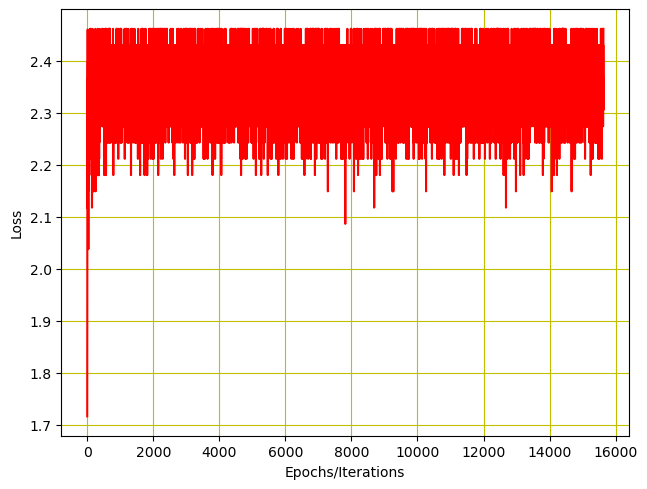

In [18]:
plt.plot(lost_list, 'r')
plt.tight_layout()
plt.grid('True', color='y')
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.show()

Now test the model 

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = nnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %
